# Previsão de Séries Temporais
## Utilizando Machine Learning para prever Temperatura

### Desenvolvido por: Gabriel Lucas de Oliveira

## 1 - Importando as bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## 2 - Lendo o dataset
- Realizando o slice para trabalhar com os dados a cada hora;
- Excluindo as colunas desnecessárias e deixando apenas a coluna de interesse (T (degC));
- Mudando o índice do Dataframe para a coluna 'Date Time' e mudando o tipo dos elementos (de object para datetime);
- Mostrando os primeiros elementos do Dataframe

In [2]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df = df[5::6]
df = df[['Date Time', 'T (degC)']]
df = df.set_index('Date Time')
df.index = pd.to_datetime(df.index)

df.head()


,T (degC)
Date Time,
2009-01-01 01:00:00,-8.05
2009-01-01 02:00:00,-8.88
2009-01-01 03:00:00,-8.81
2009-01-01 04:00:00,-9.05
2009-01-01 05:00:00,-9.63


- Plotando os dados para verificar a sazonalidade e possíveis outliers

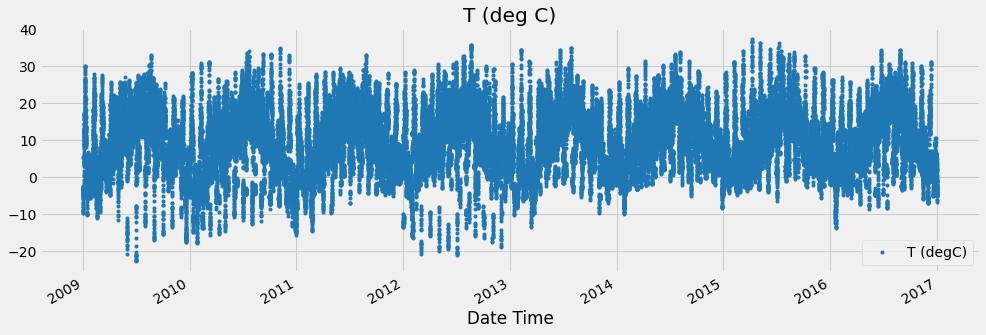

In [3]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='T (deg C)')
plt.show()

# 3 - Dividindo os dados em treino e teste
- Separou-se os dados do ano de 2016 para teste e o resto para treinamento
- Plotou-se os dados para melhor visualização

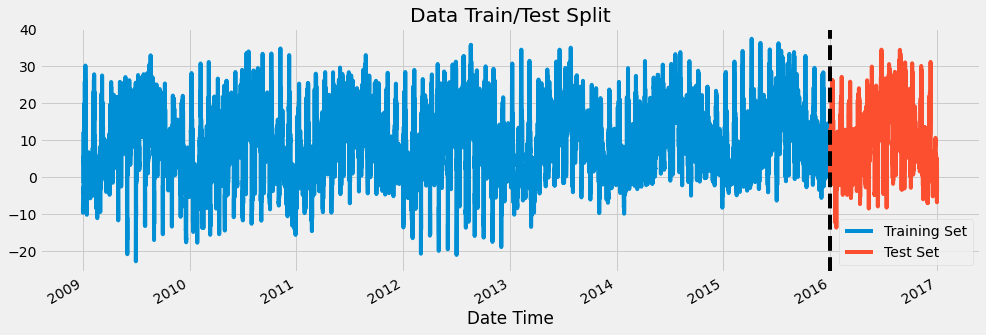

In [4]:
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# 4 - Cross Validation Split
- Utilizou-se a Cross Validation para dividir o treino e teste em 5 diferentes partes e cada parte tem um dataset de teste diferente.
- Isso é importante para evitar overfitting e também para evitar a propagação de erros utilizando dados previstos para realizar novas previsões.

In [5]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

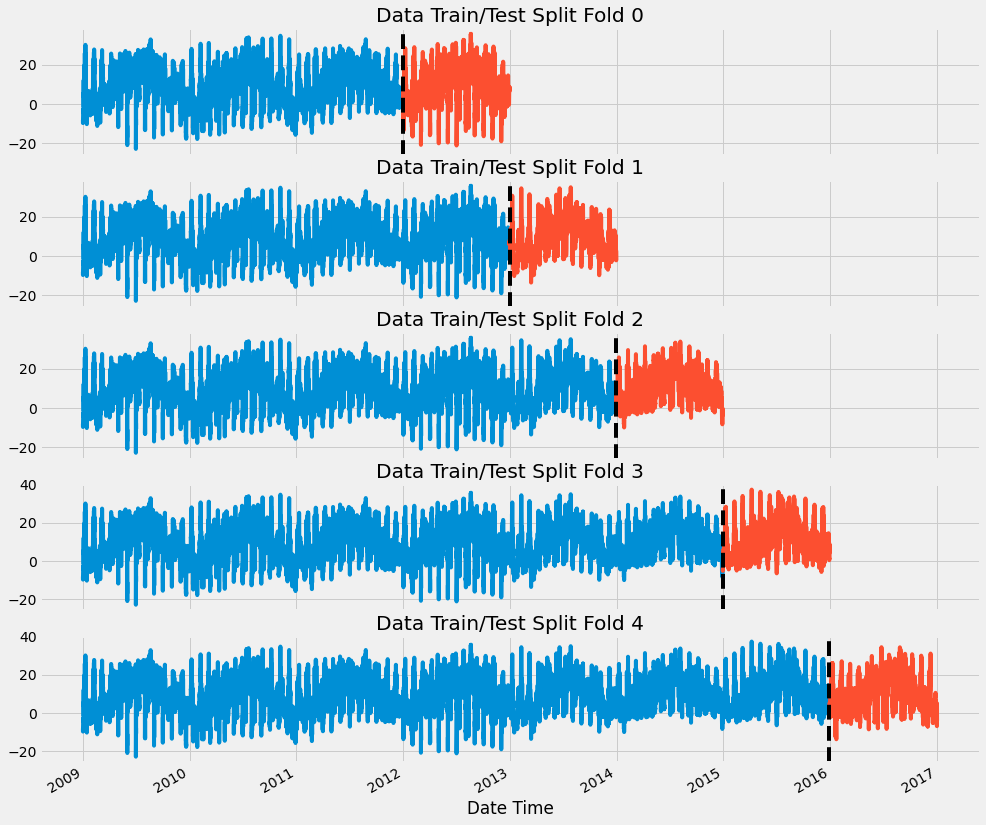

In [6]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['T (degC)'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['T (degC)'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# 5 - Adicionando Lag Features
- Foram criadas algumas features temporais;
- Adicionou-se um lag de 2 horas para que as previsões fossem feitas 2 passos à frente.

In [7]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

def add_lags(df):
    target_map = df['T (degC)'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('2 hours')).map(target_map)
    return df

In [8]:
df = create_features(df)
df = add_lags(df)
df

,T (degC),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1
Date Time,,,,,,,,,,
2009-01-01 01:00:00,-8.05,1,3,1,1,2009,1,1,1,NaN
2009-01-01 02:00:00,-8.88,2,3,1,1,2009,1,1,1,NaN
2009-01-01 03:00:00,-8.81,3,3,1,1,2009,1,1,1,-8.05
2009-01-01 04:00:00,-9.05,4,3,1,1,2009,1,1,1,-8.88
2009-01-01 05:00:00,-9.63,5,3,1,1,2009,1,1,1,-8.81
...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:10:00,-0.98,19,5,4,12,2016,366,31,52,1.29
2016-12-31 20:10:00,-1.40,20,5,4,12,2016,366,31,52,-0.42
2016-12-31 21:10:00,-2.75,21,5,4,12,2016,366,31,52,-0.98


# 6 - Treinando o modelo usando Cross Validation
- O XGBOOST é um algoritmo baseado em árvore de decisão e que utiliza uma estrutura de Gradient Boosting. Ele combina técnicas de otimização de software e hardware para produzir resultados superiores usando menos recursos de computação no menor período de tempo;
- Largamente utilizado para previsões de machine learning e séries temporais. Sendo assim, optou-se pelo uso desse modelo.

In [9]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1']
    TARGET = 'T (degC)'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[09:38:52] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11.76104	validation_1-rmse:12.62609
[100]	validation_0-rmse:4.90475	validation_1-rmse:5.37153
[200]	validation_0-rmse:2.76424	validation_1-rmse:3.13669
[300]	validation_0-rmse:2.17599	validation_1-rmse:2.51757
[400]	validation_0-rmse:1.99418	validation_1-rmse:2.32096
[500]	validation_0-rmse:1.92150	validation_1-rmse:2.25108
[600]	validation_0-rmse:1.88866	validation_1-rmse:2.21709
[700]	validation_0-rmse:1.86956	validation_1-rmse:2.20442
[800]	validation_0-rmse:1.85693	validation_1-rmse:2.20181
[900]	validation_0-rmse:1.84732	validation_1-rmse:2.19588
[999]	validation_0-rmse:1.83405	validation_1-rmse:2.18701
[09:38:57] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11.98141	validation_1-rmse:12.06126
[100]	validation_0-rmse:5.00685	validation_1-rmse:4.92250
[200]	va

In [10]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1.8098
Fold scores:[2.18700855204165, 1.6149222794054168, 1.7260284646687754, 1.8399295669523748, 1.6812633022506747]


# 7 - Fazendo previsões no conjunto de teste
- Adicionou-se uma coluna no Dataframe (Predicted T (degC)) com o resultado das previsões para comparar com os dados reais da coluna T (degC)
- Avaliou-se os resultados com a métrica RMSE

In [11]:
test['Predicted T (degC)'] = reg.predict(X_test)
test

,T (degC),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,Predicted T (degC)
Date Time,,,,,,,,,,,
2015-12-29 22:00:00,3.32,22,1,4,12,2015,363,29,53,4.54,3.952099
2015-12-29 23:00:00,2.98,23,1,4,12,2015,363,29,53,3.90,3.197452
2015-12-30 00:00:00,1.28,0,2,4,12,2015,364,30,53,3.32,2.868552
2015-12-30 01:00:00,-0.18,1,2,4,12,2015,364,30,53,2.98,2.792908
2015-12-30 02:00:00,0.03,2,2,4,12,2015,364,30,53,1.28,0.987334
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:10:00,-0.98,19,5,4,12,2016,366,31,52,1.29,0.927601
2016-12-31 20:10:00,-1.40,20,5,4,12,2016,366,31,52,-0.42,-0.827211
2016-12-31 21:10:00,-2.75,21,5,4,12,2016,366,31,52,-0.98,-1.443928


- Visualizando as previsões de forma gráfica.

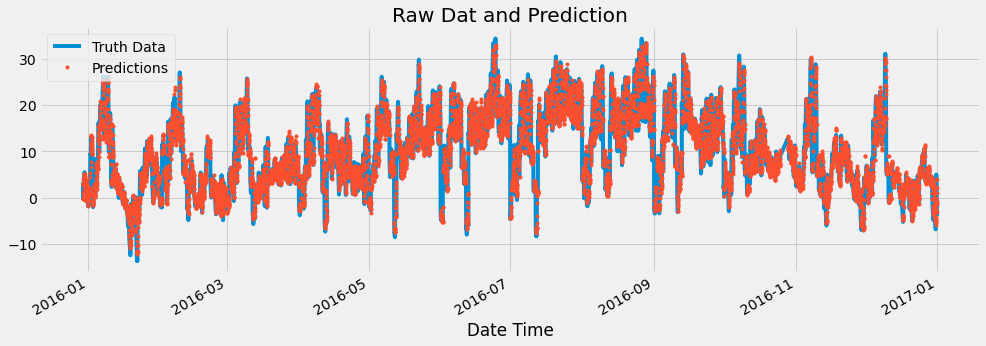

In [12]:
ax = test[['T (degC)']].plot(figsize=(15, 5))
test['Predicted T (degC)'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [13]:
score = np.sqrt(mean_squared_error(test['T (degC)'], test['Predicted T (degC)']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1.68


## Considerações Finais:
- Pelo Erro médio quadrático apresentado, temos que o modelo é consistente para realizar previsões sobre a temperatura, pois o valor encontrado é baixo;
- Há espaço para melhorias ainda, utilizarndo ferramentas como GridSearchCV e Feature Engineering para encontrar os hiperparâmetros ótimos para o modelo seria uma boa escolha. 